## Import packages

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras import layers
from tensorflow.keras import Model, metrics
from tensorflow.keras.optimizers import RMSprop, SGD

import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load data

Transformed test data to validation and removed few outliers (https://www.kaggle.com/competitions/lulc-classification/data).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/sample_data/'

In [ ]:
train_local_zip = '/content/drive/MyDrive/tra_val_total_outliers.zip'
zip_ref = zipfile.ZipFile(train_local_zip, 'r')
zip_ref.extractall(PATH)

zip_ref.close()

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [ ]:
train_dir = os.path.join(PATH, 'tra_val_total_outliers/train')
validation_dir = os.path.join(PATH, 'tra_val_total_outliers/validation')
#test_dir = os.path.join(PATH, 'test')

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

## Training and Validation Generators

In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(
                    rescale=1./255)
                    #rotation_range=45,
                    #width_shift_range=.2,
                    #height_shift_range=.2,
                    #fill_mode='wrap',
                    #horizontal_flip=True,
                    #zoom_range=0.2)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      target_size=(img_width, img_height))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
      rescale=1./255,
      )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=batch_size,
                                                                class_mode='categorical',
                                                                target_size=(img_width, img_height))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 10258 images belonging to 29 classes.
Found 1618 images belonging to 29 classes.


## Transfer learning - Create the pre-trained model

In [ ]:
import tensorflow_hub as hub

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
                   trainable=False),  # Can be True, see below.

    layers.Dense(29, activation='softmax')
])
m.build([batch_size, 240, 240, 3])  # Batch input shape.

In [ ]:
m.compile(optimizer='Adam',
          loss='categorical_crossentropy',
          metrics = ['accuracy'])

In [ ]:
initial_epochs = 5
history = m.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = initial_epochs,
                    verbose = 1)

Epoch 1/5
321/321 [==============================] - 106s 246ms/step - loss: 1.3622 - accuracy: 0.6018 - val_loss: 0.9988 - val_accuracy: 0.6947
Epoch 2/5
321/321 [==============================] - 79s 245ms/step - loss: 0.7888 - accuracy: 0.7571 - val_loss: 0.7822 - val_accuracy: 0.7781
Epoch 3/5
321/321 [==============================] - 80s 249ms/step - loss: 0.6518 - accuracy: 0.7931 - val_loss: 0.7026 - val_accuracy: 0.7892
Epoch 4/5
321/321 [==============================] - 81s 252ms/step - loss: 0.5709 - accuracy: 0.8200 - val_loss: 0.6633 - val_accuracy: 0.8053
Epoch 5/5
321/321 [==============================] - 81s 253ms/step - loss: 0.5118 - accuracy: 0.8396 - val_loss: 0.6515 - val_accuracy: 0.8053


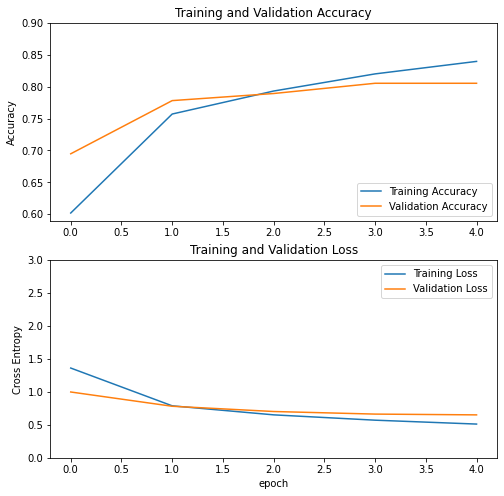

In [ ]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [ ]:
m.trainable = True
                                                     # Mejor: 1e-4
m.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
          loss = 'categorical_crossentropy',
          metrics = ['accuracy']
)

history_fine = m.fit(train_generator,
                    validation_data = validation_generator,
                    initial_epoch = history.epoch[-1],
                    epochs = 20,
                    verbose = 1)

Epoch 5/20
321/321 [==============================] - 292s 821ms/step - loss: 1.0889 - accuracy: 0.6822 - val_loss: 0.3081 - val_accuracy: 0.9085
Epoch 6/20
321/321 [==============================] - 266s 830ms/step - loss: 0.4389 - accuracy: 0.8511 - val_loss: 0.1855 - val_accuracy: 0.9376
Epoch 7/20
321/321 [==============================] - 267s 831ms/step - loss: 0.3071 - accuracy: 0.8907 - val_loss: 0.1725 - val_accuracy: 0.9357
Epoch 8/20
321/321 [==============================] - 266s 830ms/step - loss: 0.2350 - accuracy: 0.9187 - val_loss: 0.1762 - val_accuracy: 0.9444
Epoch 9/20
321/321 [==============================] - 267s 830ms/step - loss: 0.1840 - accuracy: 0.9354 - val_loss: 0.1815 - val_accuracy: 0.9339
Epoch 10/20
321/321 [==============================] - 267s 831ms/step - loss: 0.1627 - accuracy: 0.9422 - val_loss: 0.1421 - val_accuracy: 0.9444
Epoch 11/20
321/321 [==============================] - 267s 831ms/step - loss: 0.1407 - accuracy: 0.9516 - val_loss: 0.1164

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

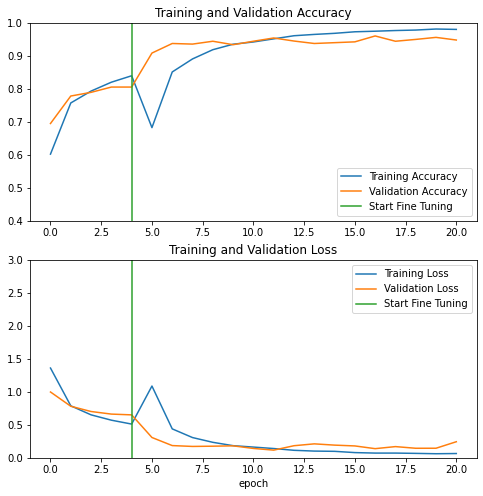

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
m.compile(optimizer=tf.keras.optimizers.Adam(5e-5),  # Low learning rate
          loss = 'categorical_crossentropy',         # Mejor: 5e-5
          metrics = ['accuracy']
)

history_refine = m.fit(train_generator,
                    validation_data = validation_generator,
                    initial_epoch = history_fine.epoch[-1],
                    epochs = 30,
                    verbose = 1)

Epoch 20/30
321/321 [==============================] - 276s 816ms/step - loss: 0.0375 - accuracy: 0.9882 - val_loss: 0.1746 - val_accuracy: 0.9462
Epoch 21/30
321/321 [==============================] - 265s 826ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 0.1463 - val_accuracy: 0.9574
Epoch 22/30
321/321 [==============================] - 266s 828ms/step - loss: 0.0244 - accuracy: 0.9935 - val_loss: 0.1906 - val_accuracy: 0.9598
Epoch 23/30
321/321 [==============================] - 266s 830ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.2156 - val_accuracy: 0.9431
Epoch 24/30
321/321 [==============================] - 266s 829ms/step - loss: 0.0209 - accuracy: 0.9934 - val_loss: 0.1934 - val_accuracy: 0.9604
Epoch 25/30
321/321 [==============================] - 266s 829ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.1861 - val_accuracy: 0.9506
Epoch 26/30
321/321 [==============================] - 266s 828ms/step - loss: 0.0211 - accuracy: 0.9939 - val_loss: 0

In [ ]:
acc += history_refine.history['accuracy']
val_acc += history_refine.history['val_accuracy']

loss += history_refine.history['loss']
val_loss += history_refine.history['val_loss']

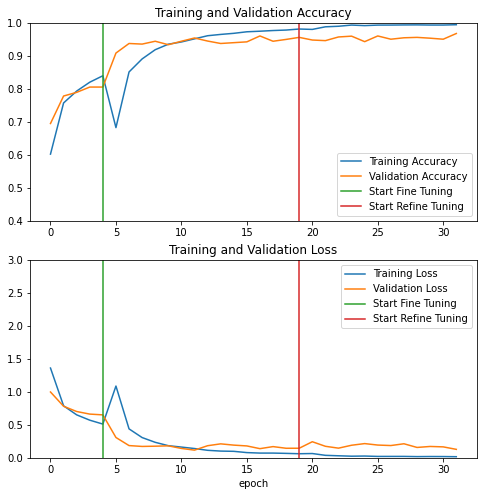

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Refine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Refine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
m.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
          loss = 'categorical_crossentropy',         # Mejor: 1e-5
          metrics = ['accuracy']
)

history_rerefine = m.fit(train_generator,
                    validation_data = validation_generator,
                    initial_epoch = history_refine.epoch[-1],
                    epochs = 40,
                    verbose = 1)

Epoch 30/40
321/321 [==============================] - 281s 833ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.1813 - val_accuracy: 0.9648
Epoch 31/40
321/321 [==============================] - 266s 829ms/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 0.1425 - val_accuracy: 0.9710
Epoch 32/40
321/321 [==============================] - 266s 829ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.1455 - val_accuracy: 0.9703
Epoch 33/40
321/321 [==============================] - 266s 830ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.1518 - val_accuracy: 0.9722
Epoch 34/40
321/321 [==============================] - 266s 829ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.1871 - val_accuracy: 0.9642
Epoch 35/40
321/321 [==============================] - 266s 830ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.1678 - val_accuracy: 0.9648
Epoch 36/40
321/321 [==============================] - 266s 830ms/step - loss: 0.0053 - accuracy: 0.9981 - val_loss: 0

In [ ]:
acc += history_rerefine.history['accuracy']
val_acc += history_rerefine.history['val_accuracy']

loss += history_rerefine.history['loss']
val_loss += history_rerefine.history['val_loss']

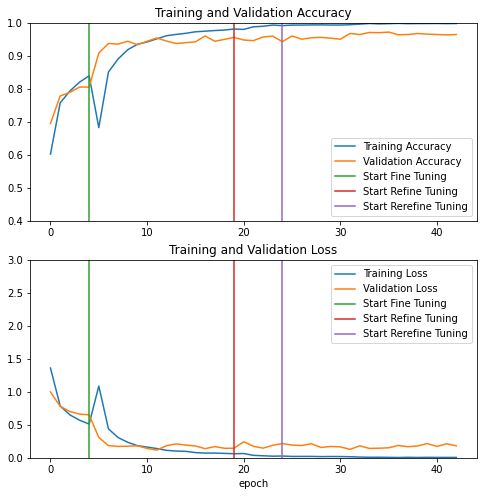

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Refine Tuning')
plt.plot([25-1,25-1],
          plt.ylim(), label='Start Rerefine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Refine Tuning')
plt.plot([25-1,25-1],
          plt.ylim(), label='Start Rerefine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()